In [1]:
import numpy as np
import sys
sys.path
sys.path.insert(0, '/Users/asaadeldin/Downloads/GitHub/graspologic')

In [2]:
from graspologic.simulations import sbm_corr
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.match import GraphMatch
import numpy as np

# Experiment Summary
Let $(G_1, G_2) \sim \rho-SBM(\vec{n},B)$. (NB: binary, symmetric, hollow.)

$K = 3$.

the marginal SBM is conditional on block sizes $\vec{n}=[n_1,n_2,n_3]$.

$B = [(.20,.01,.01);(.01,.10,.01);(.01,.01,.20)]$. (NB: rank($B$)=3 with evalues $\approx [0.212,0.190,0.098]$.)

with $n = 150$ and $\vec{n}=[n_1,n_2,n_3] = [50,50,50]$

for each $\rho \in \{0,0.1,\cdots,0.9,1.0\}$ generate $r$ replicates $(G_1, G_2)$.

For all $r$ replicates, run $GM$ and $GM_{SS}$ each $t$ times, with each $t$ corresponding to a different random permutation on $G_2$. 

Specifically,$G_2' = Q G_2 Q^T,$ where $Q$ is sampled uniformly from the set of $n x n$ permutations matrices.

For each $t$ permutation, run $GM$ & $GM_{SS}$ from the barycenter ($\gamma = 0$).

For each $r$, the $t$ permutation with the highest associated objective function value will have it's match ratio recorded

For any $\rho$ value, have $\delta$ denote the average match ratio over the $r$ realizations

Plot $x=\rho$ vs $y$= $\delta$ $\pm$ 2s.e.

This notebook contains figures for $r=100$, $t=50$ 

# Description of $GM_{ss}$ Procedure
For each $r$, ASE each graph into $d=3$ yielding $\hat{X}_1$ & $\hat{X}_2$

MedianFlip both into the first orthant yielding $\bar{X}_1$ & $\bar{X_2}$

let $Phat = \bar{X}_1 \bar{X}_2^T$ and run $t$ repititions of gm with $G_1,G_2 and Phat$ as the similarity. 

In [3]:
gmp = GraphMatch()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from joblib import Parallel, delayed
import seaborn as sns
from graspy.match import GraphMatch as GMP
from graspy.simulations import sbm_corr
from graspy.embed import AdjacencySpectralEmbed

r = 100
t=10

def match_ratio(inds, n):
    return np.count_nonzero(inds == np.arange(n)) / n
def _median_sign_flips(X1, X2):
    X1_medians = np.median(X1, axis=0)
    X2_medians = np.median(X2, axis=0)
    val1 = np.sign(X1_medians).astype(int)
    X1 = np.multiply(val1.reshape(-1, 1).T, X1)
    val2 = np.sign(X2_medians).astype(int)
    X2 = np.multiply(val2.reshape(-1, 1).T, X2)
    return X1, X2
        
n = 150
m = r
rhos = 0.1 * np.arange(11)[5:]
# rhos = np.arange(5,10.5,0.5) *0.1
n_p = len(rhos)

ratios = np.zeros((n_p,m))
scores = np.zeros((n_p,m))

ratios_ss = np.zeros((n_p,m))
scores_ss = np.zeros((n_p,m))

n_per_block = int(n/3)
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
block_probs = np.array([[0.2, 0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 0.2]])
directed = False
loops = False
for k, rho in enumerate(rhos):
    np.random.seed(8888)
    seeds = [np.random.randint(1e8, size=t) for i in range(m)]
    def run_sim(seed):

        A1, A2 = sbm_corr(
            block_members, block_probs, rho, directed=directed, loops=loops
        )
        ase = AdjacencySpectralEmbed(n_components=3, algorithm='truncated')
        x1 = ase.fit_transform(A1)
        x2 = ase.fit_transform(A2)
        xh1, xh2 = _median_sign_flips(x1,x2)
        S = xh1 @ xh2.T

        score = 0
        res_opt = None

        score_ss = 0
        res_opt_ss = None

        for j in range(t):
            res = gmp.fit(A1,A2, rng=seed[j])
            if res.score_>score:
                perm = res.perm_inds_
                score = res.score_

            res_ss = gmp.fit(A1,A2, S=S, rng= seed[j])
            if res.score_>score_ss:
                perm_ss = res_ss.perm_inds_
                score_ss = res.score_

        ratio = match_ratio(perm, n)

        ratio_ss = match_ratio(perm_ss, n)

        return ratio, score, ratio_ss, score_ss

    result = Parallel(n_jobs=-1, verbose=10)(delayed(run_sim)(seed) for seed in seeds)

    ratios[k,:] = [item[0] for item in result]
    scores[k,:] = [item[1] for item in result]
    ratios_ss[k,:] = [item[2] for item in result]
    scores_ss[k,:] = [item[3] for item in result]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  17 t

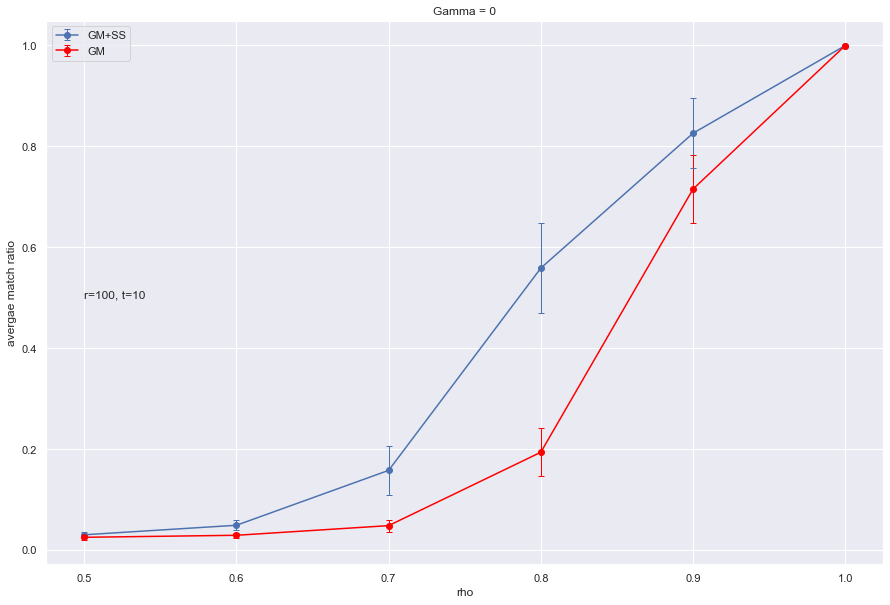

In [17]:
from scipy.stats import sem
error = [2*sem(ratios[i,:]) for i in range(n_p)]
average = [np.mean(ratios[i,:] ) for i in range(n_p)]

error_ss = [2*sem(ratios_ss[i,:]) for i in range(n_p)]
average_ss = [np.mean(ratios_ss[i,:] ) for i in range(n_p)]
sns.set_context('paper')
sns.set(rc={'figure.figsize':(15,10)})
txt =f'r={r}, t={t}'
plt.errorbar(rhos,average_ss, error_ss,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM+SS')
plt.errorbar(rhos,average, error,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM', color='red')
plt.xlabel("rho")
plt.ylabel("avergae match ratio")
plt.text(0.5,0.5,txt)
plt.title('Gamma = 0')
plt.legend()